<h1 align="center"> Portfolio 3: Choice Modeling Algorithm  </h1>

#### by Muhammad Kevin Alrahmanto (muhammad.kevin@mail.ugm.ac.id / kevinalrahmantomuhammad@gmail.com)

Besides standard regression analysis, I think it is also worth noting to consider some algorithms that could model consumer preferences to make more comprehensive quantitative research. There are numerous algorithms available for choice modeling in some of publication journals. But here, in this notebook, I will try to implement two algorithms: the Bradley-Terry tree model proposed by Strobl et al. (2011) and partial ranking model proposed by Hatzinger & Dittrich (2012).

The details on how these algorithms work can be found in these links:

- Rasch Trese:  Accounting for Individual Differences in Bradley-Terry Models by Means of Recursive Partitioning (https://doi.org/10.3102/1076998609359791)
- Partial Ranking: prefmod: An R Package for Modeling Preferences Based on Paired Comparisons, Rankings, or Ratings (https://ideas.repec.org/a/jss/jstsof/v048i10.html)

In [1]:
getwd()

[1] "C:/Users/Kevin"

In [2]:
library(pacman)
pacman::p_load(dplyr, tidyr, forcats, ggplot2, psych, ggpubr, repr, psychotree, prefmod  )

Warning message:
"package 'pacman' was built under R version 4.2.3"


<div class="alert-info">
<font color='blue'>
<h3 align="center">
~ 

# 1. German dataset (2007): Who is the most attractive contestant? (Paired Comparison using Bradley-Terry Tree Model)

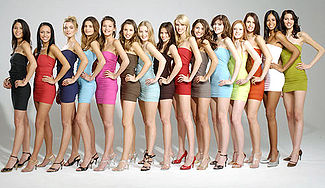
<h4 align="center"> https://www.prosieben.de/lifestyle_magazine

**Dataset**: Topmodel2007 (Preferences of 192 respondents judging the attractiveness of the top six contestants of the TV show Germany’s Next Topmodel 2007 (second cycle))

**Categorical variables:**
- gender
- age 
- q1: Do you know the TV show Germany’s Next Topmodel?
- q2: Did you watch Germany’s Next Topmodel regularly?
- q3: Did you watch the final show of Germany’s Next Topmodel?

## 1.1 Exploratory Data Analysis

In [3]:
data("Topmodel2007")
head(Topmodel2007)

,preference,gender,age,q1,q2,q3
,"<paircomp[,15]>",<fct>,<int>,<fct>,<fct>,<fct>
1,"1, 1, 1, 1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1",male,66,no,no,no
2,"-1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1",male,21,yes,yes,yes
3,"-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1",female,21,yes,yes,yes
4,"-1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1",female,20,yes,no,yes
5,"-1, -1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1",male,21,yes,yes,yes
6,"-1, -1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1",female,20,yes,no,yes


### 1.1.1 Respondent Characteristics

In [4]:
summary(Topmodel2007[, c(-1)])

    gender        age          q1        q2        q3     
 male  :96   Min.   :15.00   yes:111   yes: 35   yes: 84  
 female:96   1st Qu.:23.00   no : 81   no :157   no :108  
             Median :30.00                                
             Mean   :34.81                                
             3rd Qu.:47.00                                
             Max.   :77.00                                

In [5]:
freq_dat <- Topmodel2007 %>% group_by(gender, q1, q2, q3)  %>% tally()
freq_dat

gender,q1,q2,q3,n
<fct>,<fct>,<fct>,<fct>,<int>
male,yes,yes,yes,11
male,yes,no,yes,18
male,yes,no,no,20
male,no,no,yes,2
male,no,no,no,45
female,yes,yes,yes,24
female,yes,no,yes,28
female,yes,no,no,10
female,no,no,yes,1


In [6]:
sum_df <- data.frame(summary(Topmodel2007$preference))
colnames(sum_df) <- c('>', '<')
sum_df$abs_difference <- abs(sum_df[, 1]-sum_df[, 2])
contestant <- t(data.frame(strsplit(rownames(summary(Topmodel2007$preference)), ':')))
final_sum <-cbind(sum_df, 
                   data.frame(win=ifelse(sum_df[,1 ] > sum_df[,2 ], 
                                         contestant[, 1], contestant[, 2])))
final_sum <- final_sum[order(row.names(final_sum)), ]
final_sum

,>,<,abs_difference,win
,<int>,<int>,<int>,<chr>
Anni : Anja,112,80,32,Anni
Anni : Fiona,81,111,30,Fiona
Anni : Hana,75,117,42,Hana
Anni : Mandy,114,78,36,Anni
Barbara : Anja,123,69,54,Barbara
Barbara : Anni,121,71,50,Barbara
Barbara : Fiona,101,91,10,Barbara
Barbara : Hana,98,94,4,Barbara
Barbara : Mandy,130,62,68,Barbara


In [7]:
sort(table(gsub(" ", "",final_sum$win)))


   Anja    Anni   Fiona    Hana Barbara 
      1       2       3       4       5 

In [8]:
topmtree <- bttree(preference ~ age + gender + q1 + q2 + q3,data = Topmodel2007)
topmtree

Bradley-Terry tree

Model formula:
preference ~ age + gender + q1 + q2 + q3

Fitted party:
[1] root
|   [2] age <= 52
|   |   [3] q2 in yes: n = 35
|   |         Barbara      Anni      Hana     Fiona     Mandy 
|   |       1.3378103 1.2318343 2.0498718 0.8339361 0.6217203 
|   |   [4] q2 in no
|   |   |   [5] gender in male: n = 71
|   |   |           Barbara        Anni        Hana       Fiona       Mandy 
|   |   |        0.43866327  0.08877441  0.84629138  0.69423818 -0.10002806 
|   |   |   [6] gender in female: n = 56
|   |   |          Barbara       Anni       Hana      Fiona      Mandy 
|   |   |        0.9475317  0.7245863  0.4452383  0.6349857 -0.4965404 
|   [7] age > 52: n = 30
|          Barbara       Anni       Hana      Fiona      Mandy 
|        0.2177619 -1.3166332 -0.3059146 -0.2590749 -0.2356528 

Number of inner nodes:    3
Number of terminal nodes: 4
Number of parameters per node: 5
Objective function (negative log-likelihood): 1828.633

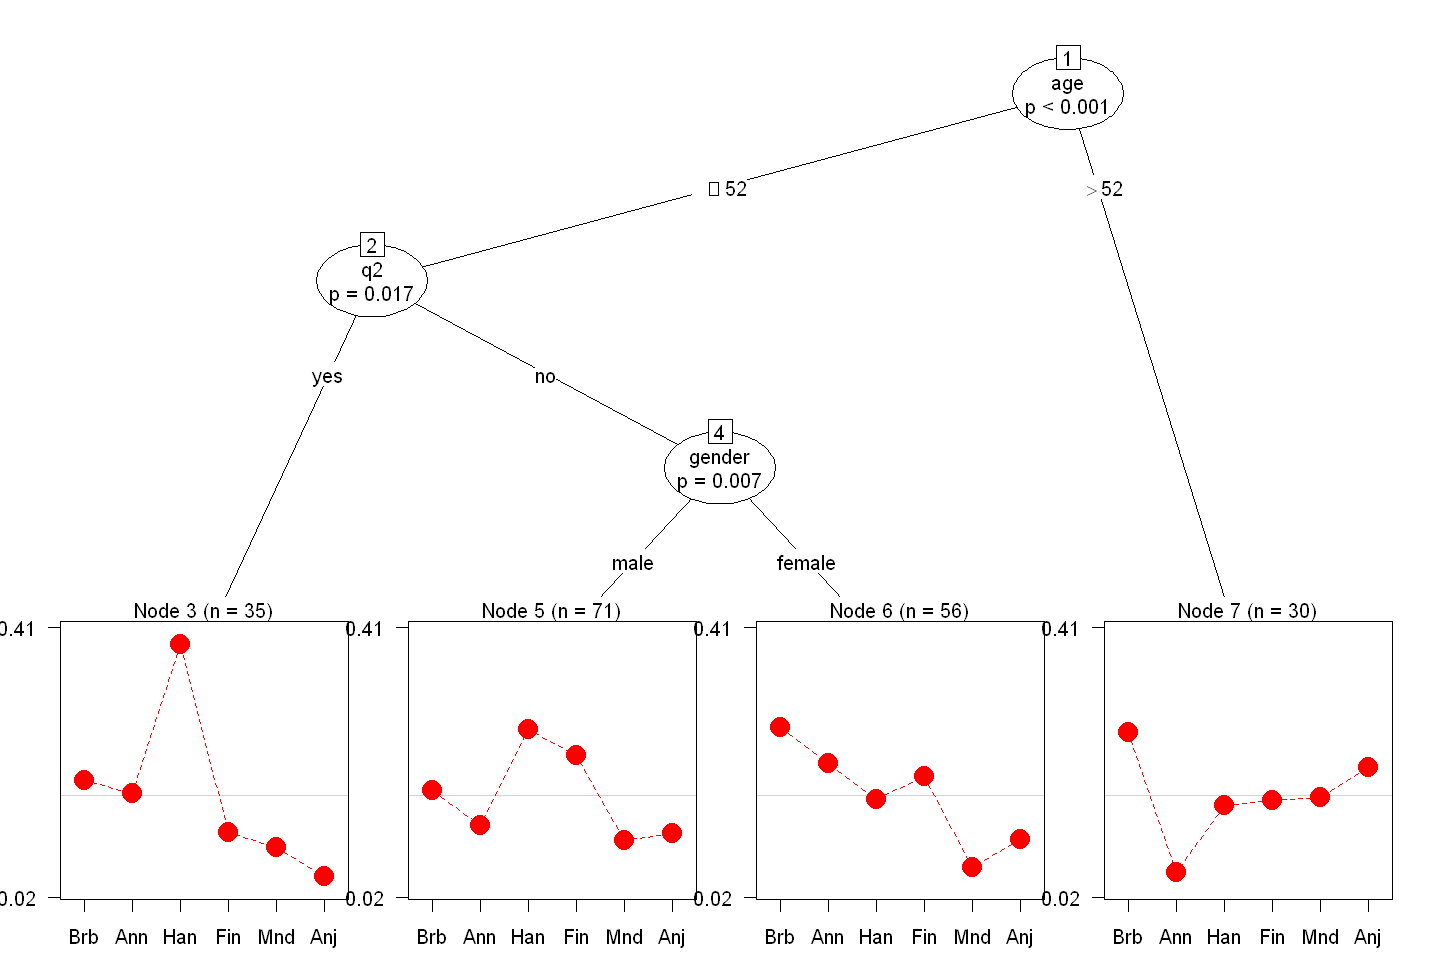

In [9]:
options(repr.plot.width=12, repr.plot.height=8)
par(mfrow=c(2,2), mar=c(5,6,5,1)+1.5)
plot(topmtree, cex = 1.3,pch = c(19), col = c('red'))

<div class="alert-info">
<font color='blue'>
<h3 align="center">
~ 

# 2. German dataset (2009): What kind of cars do people really want? (Partial Ranking Modeling)

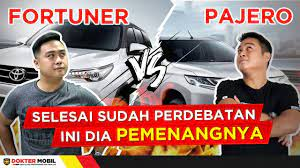
<h4 align="center"> https://www.youtube.com/watch?v=NmsFxqHUdmw

**Dataset**: carconf (The data consist of 435 respondents being asked to customize a virtual car based on their personal preferences. They had the freedom to select different components from various configuration. Some of the options they could choose are the exterior and interior design, technical equipment, brand, price, and country of manufacture. The order in which they picked for the different configuration was recorded using a ranking system. Since participants were not required to pick an item from every single category, their choices resulted in a partial ranking rather than a full ranking.)

**Original dataset**: Zielgruppenadäquate Abläufe in Konfigurationssystemen - eine empirische Studie im Automobilmarkt: Das Paarvergleichs-Pattern-Modell für Partial Rankings (https://research.wu.ac.at/de/publications/zielgruppenad%C3%A4quate-abl%C3%A4ufe-in-konfigurationssystemen-eine-empiri-3)

**Categorical variables:**
- sex
- age (1 = 17–29 years, 2 = 30–49 years, 3 = 50 years and older)

In [10]:
data("carconf")

In [11]:
head(carconf)

,price,exterior,brand,tech.equip,country,interior,sex,age,segment
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,3,2,5,6,4,1,2,1,1
2,4,1,5,2,6,3,2,3,1
3,6,3,2,5,4,1,2,2,1
4,1,4,2,3,6,5,2,3,2
5,NA,2,4,NA,3,1,1,2,2
6,NA,2,4,3,NA,1,1,1,1


In [12]:
carconf_vis <- carconf

In [13]:
carconf_vis$sex <- carconf[,7] %>% factor()  %>% fct_recode('Female'='1', 'Male'='2')
carconf_vis$age <- carconf[,8] %>% factor()  %>% fct_recode('17–29'='1','30–49'='2','>50'='3')

In [14]:
round(sort(colMeans(carconf_vis[, 1:6], na.rm = T)),2)

exterior tech.equip      brand   interior      price    country 
      2.88       3.11       3.17       3.18       3.53       4.39

In [15]:
sapply(carconf_vis[, 1:6], function(x) by(x, carconf_vis$sex, mean, na.rm=T))

,price,exterior,brand,tech.equip,country,interior
Female,3.449198,2.671642,3.138095,3.251309,4.518293,3.166667
Male,3.601990,3.078341,3.191111,2.976636,4.266304,3.197183


In [16]:
sapply(carconf_vis[, 1:6], function(x) by(x, carconf_vis$age, mean, na.rm=T))

,price,exterior,brand,tech.equip,country,interior
17–29,3.705521,2.867403,2.989071,3.340909,4.551948,3.039773
30–49,3.435897,2.944444,3.325581,3.201681,4.174312,3.235772
>50,3.361111,2.837838,3.260163,2.627273,4.352941,3.358491


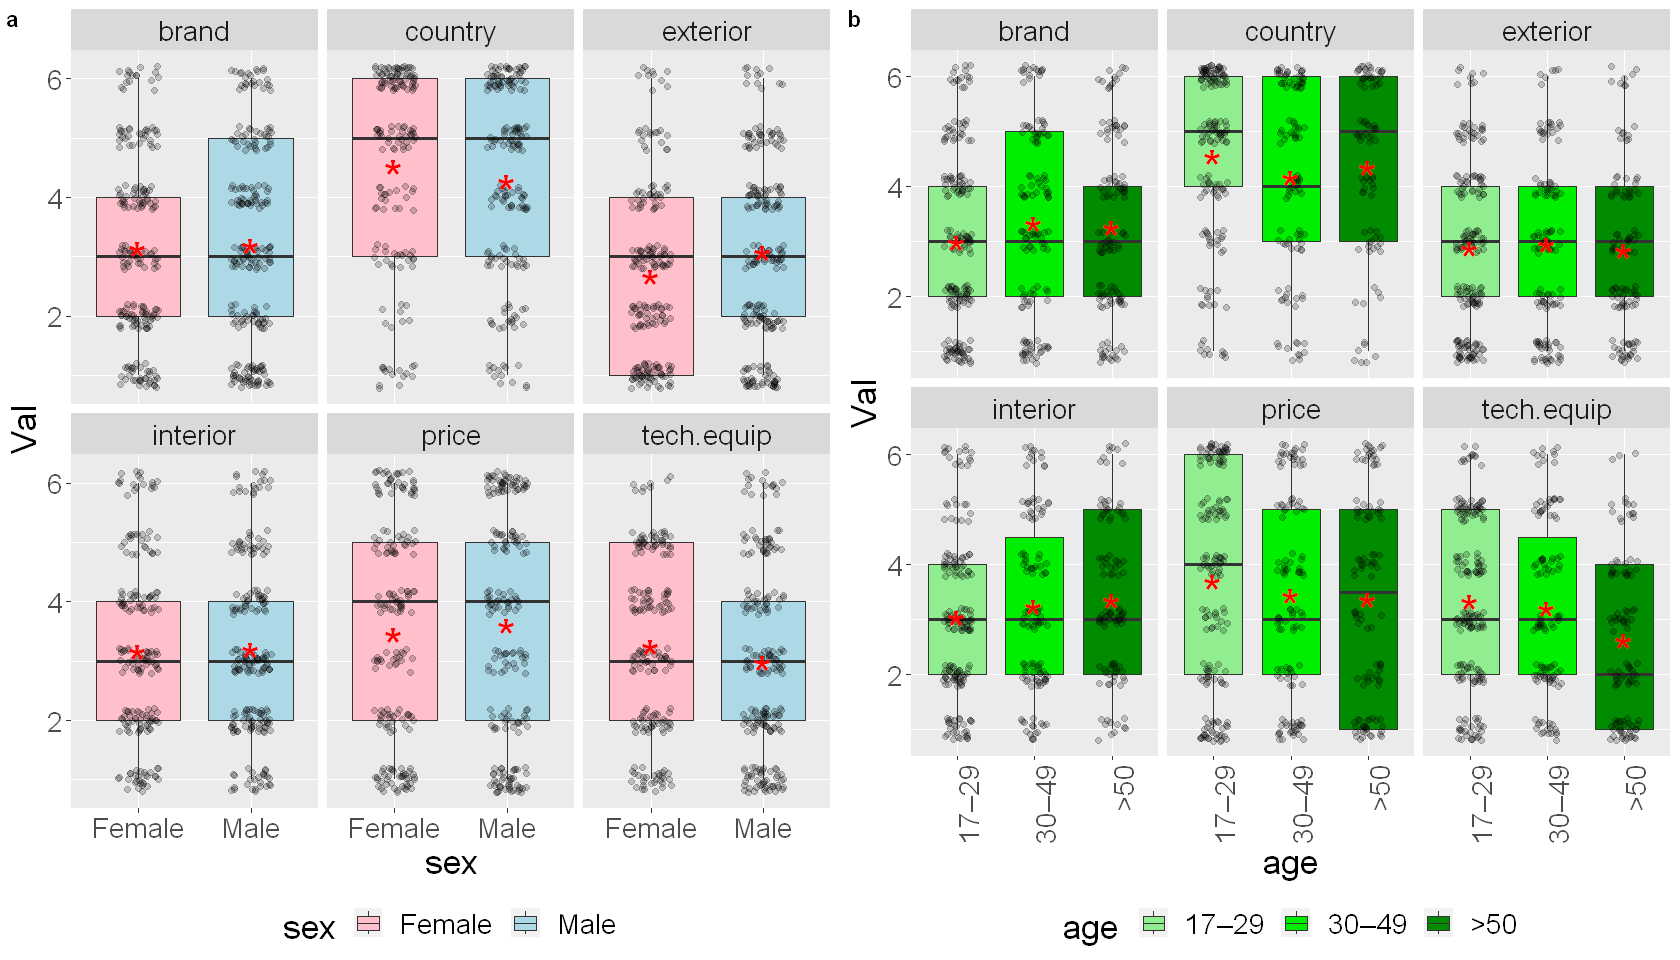

In [17]:
options(repr.plot.width=14, repr.plot.height=8 )
carconf_long <- carconf_vis[, 1:8]%>%gather('Vars', 'Val', -sex, -age)%>%na.omit(.)  
a <- carconf_long  %>% ggplot(aes(sex, Val))+geom_boxplot(aes(fill=sex))+theme(text=element_text(size=21))+
geom_jitter(height=0.21,width=0.18, alpha=0.2)+facet_wrap(~Vars)+scale_fill_manual(values=c( "pink", "lightblue"))+
stat_summary(geom = 'point', fun = mean, col='red', size=10, pch='*')
b<-carconf_long  %>% ggplot(aes(age, Val))+geom_boxplot(aes(fill=age))+theme(text=element_text(size=21),axis.text.x = element_text(angle = 90, vjust = 1, hjust=1))+
geom_jitter(height=0.21,width=0.18, alpha=0.2)+facet_wrap(~Vars)+scale_fill_manual(values=c( "lightgreen", "green2",'green4'))+
stat_summary(geom = 'point', fun = mean, col='red', size=10, pch='*')
ggarrange(a, b,nrow=1, ncol=2, labels=c("a","b"),common.legend = F, legend = "bottom")

In [18]:
mod.car.0<-pattR.fit(carconf,6)
mod.car.0


Results of pattern model for rankings 

Call:
pattR.fit(obj = carconf, nitems = 6) 

Deviance:  1163.188 
log likelihood:  -2653.605 

no of iterations:  9  (Code: 1 )

           estimate      se       z p-value
price      -0.05984 0.01878  -3.186  0.0014
exterior    0.05295 0.01891   2.800  0.0051
brand       0.02134 0.01868   1.142  0.2535
tech.equip  0.01094 0.01874   0.584  0.5592
country    -0.21035 0.02047 -10.276  0.0000

<font color='blue'>
<h4 align="left">
In general, exterior and brand are the most important component for choosing car

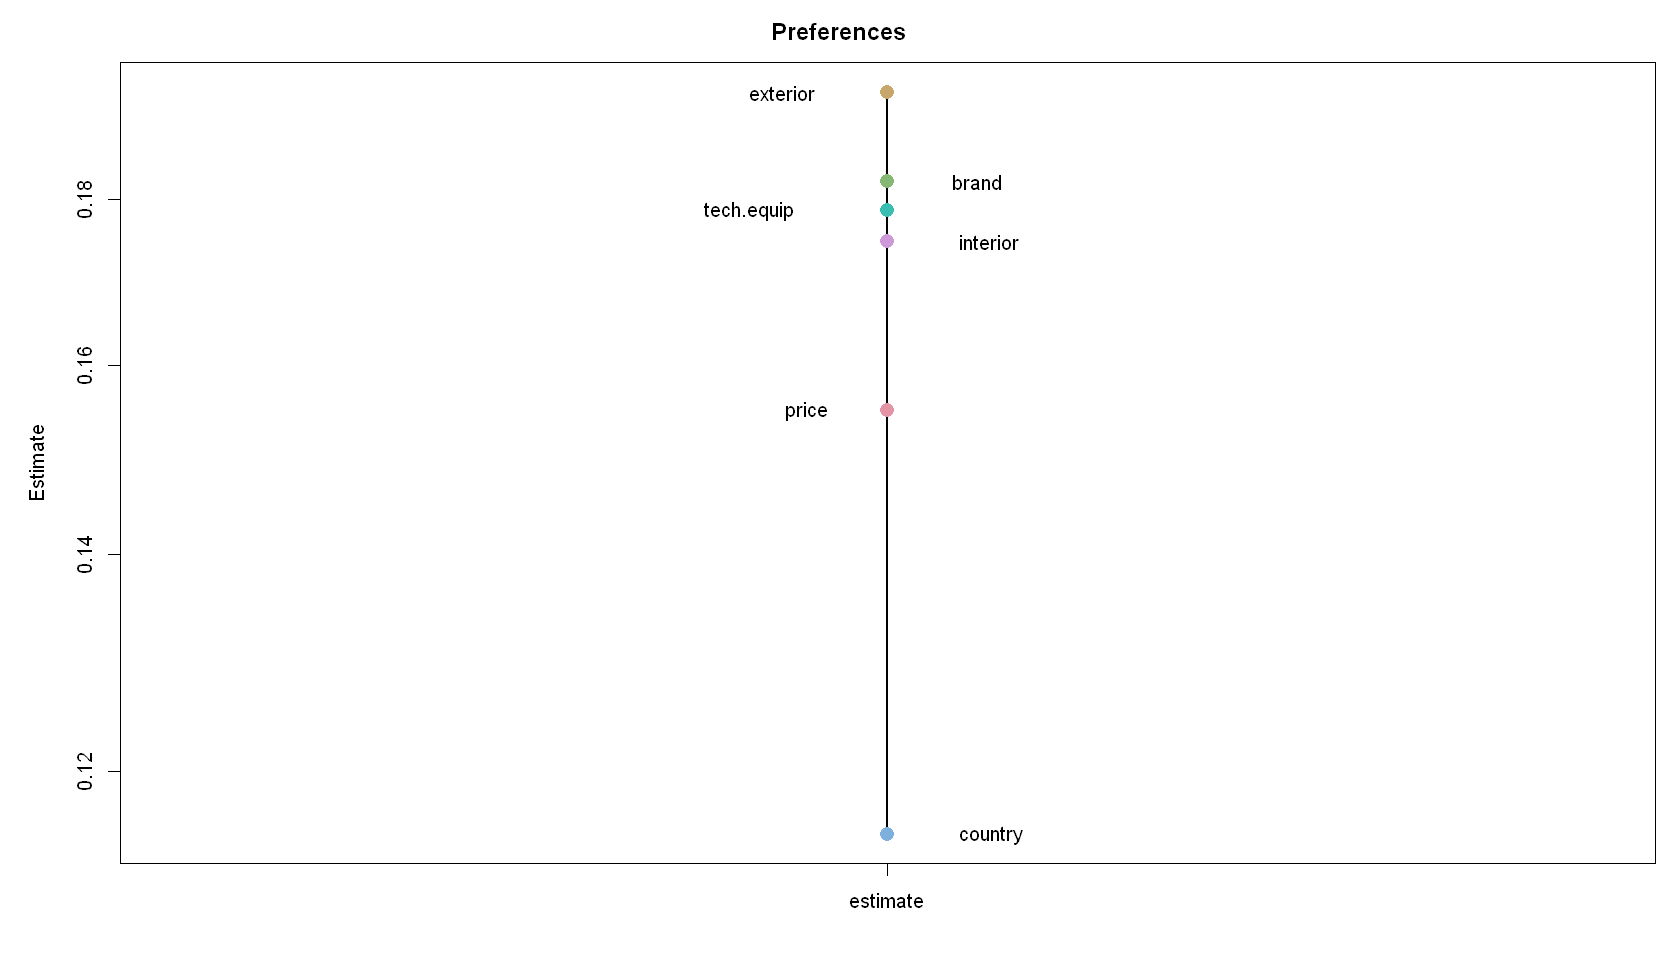

In [19]:
options(repr.plot.width=14, repr.plot.height=8 )
worth_0<-patt.worth(mod.car.0)
plot(worth_0,log="y", lwd=2) 

<font color='blue'>
<h4 align="left">
Tech equipment is more prioritized by men and older people

In [20]:
mod.car.sex<-pattR.fit(carconf,6,formel=~sex)
mod.car.sex


Results of pattern model for rankings 

Call:
pattR.fit(obj = carconf, nitems = 6, formel = ~sex) 

Deviance:  1558.026 
log likelihood:  -2647.275 
eliminated term(s):  ~sex 

no of iterations:  25  (Code: 1 )

                estimate      se      z p-value
price           -0.04589 0.02721 -1.687  0.0916
exterior         0.08917 0.02787  3.199  0.0014
brand            0.02789 0.02712  1.029  0.3035
tech.equip      -0.01324 0.02714 -0.488  0.6255
country         -0.23706 0.03052 -7.767  0.0000
price:sex2      -0.02692 0.03765 -0.715  0.4746
exterior:sex2   -0.06769 0.03806 -1.778  0.0754
brand:sex2      -0.01247 0.03746 -0.333  0.7391
tech.equip:sex2  0.04641 0.03761  1.234  0.2172
country:sex2     0.04841 0.04124  1.174  0.2404

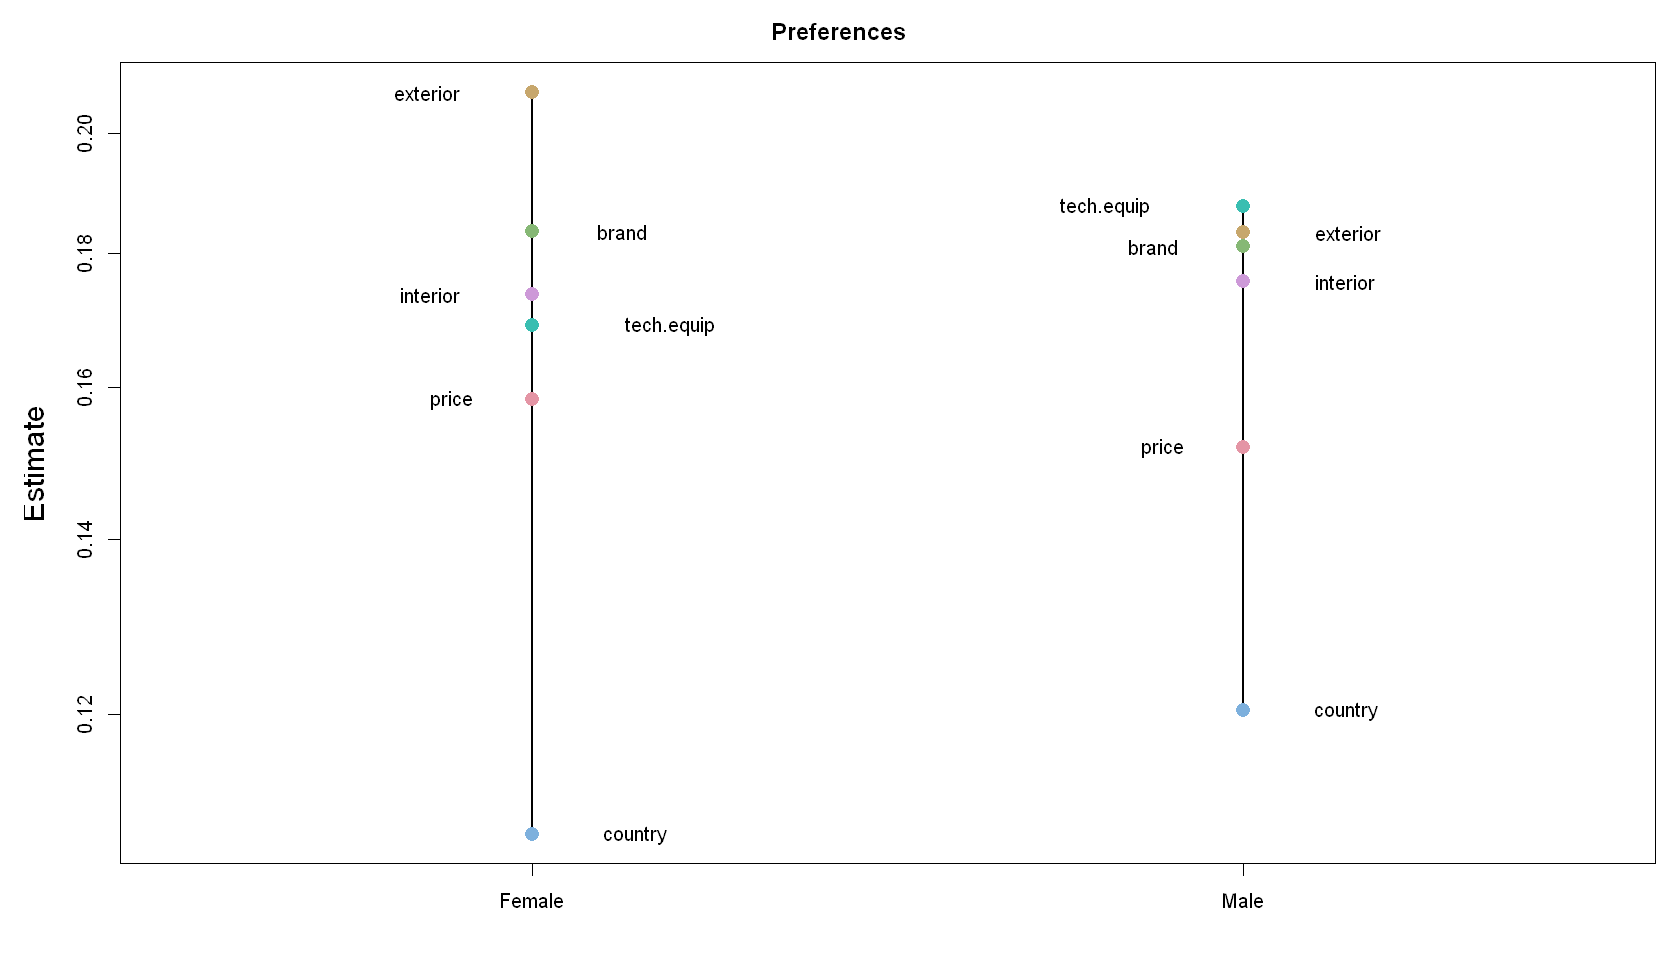

In [21]:
options(repr.plot.width=14, repr.plot.height=8 )
worth_sex<-patt.worth(mod.car.sex)
colnames(worth_sex)<-c("Female","Male")
plot(worth_sex,log="y", cex=1.1, cex.lab=1.5,cex.axis=2, lwd=2) 

In [22]:
carconf1 <- carconf[, c(1:6, 8)]
mod.car.age <- pattR.fit(carconf1, nitems = 6, formel = ~ age)
mod.car.age


Results of pattern model for rankings 

Call:
pattR.fit(obj = carconf1, nitems = 6, formel = ~age) 

Deviance:  1772.935 
log likelihood:  -2642.14 
eliminated term(s):  ~age 

no of iterations:  38  (Code: 1 )

                estimate      se      z p-value
price           -0.11658 0.02949 -3.953  0.0001
exterior         0.03656 0.02948  1.240  0.2150
brand            0.02036 0.02930  0.695  0.4871
tech.equip      -0.04360 0.02906 -1.500  0.1336
country         -0.26050 0.03255 -8.003  0.0000
price:age2       0.07488 0.04499  1.664  0.0961
exterior:age2    0.01337 0.04521  0.296  0.7672
brand:age2      -0.02031 0.04476 -0.454  0.6498
tech.equip:age2  0.03947 0.04469  0.883  0.3772
country:age2     0.09782 0.04837  2.022  0.0432
price:age3       0.12133 0.04629  2.621  0.0088
exterior:age3    0.04558 0.04653  0.979  0.3276
brand:age3       0.02727 0.04595  0.593  0.5532
tech.equip:age3  0.15565 0.04670  3.333  0.0009
country:age3     0.06621 0.05138  1.289  0.1974

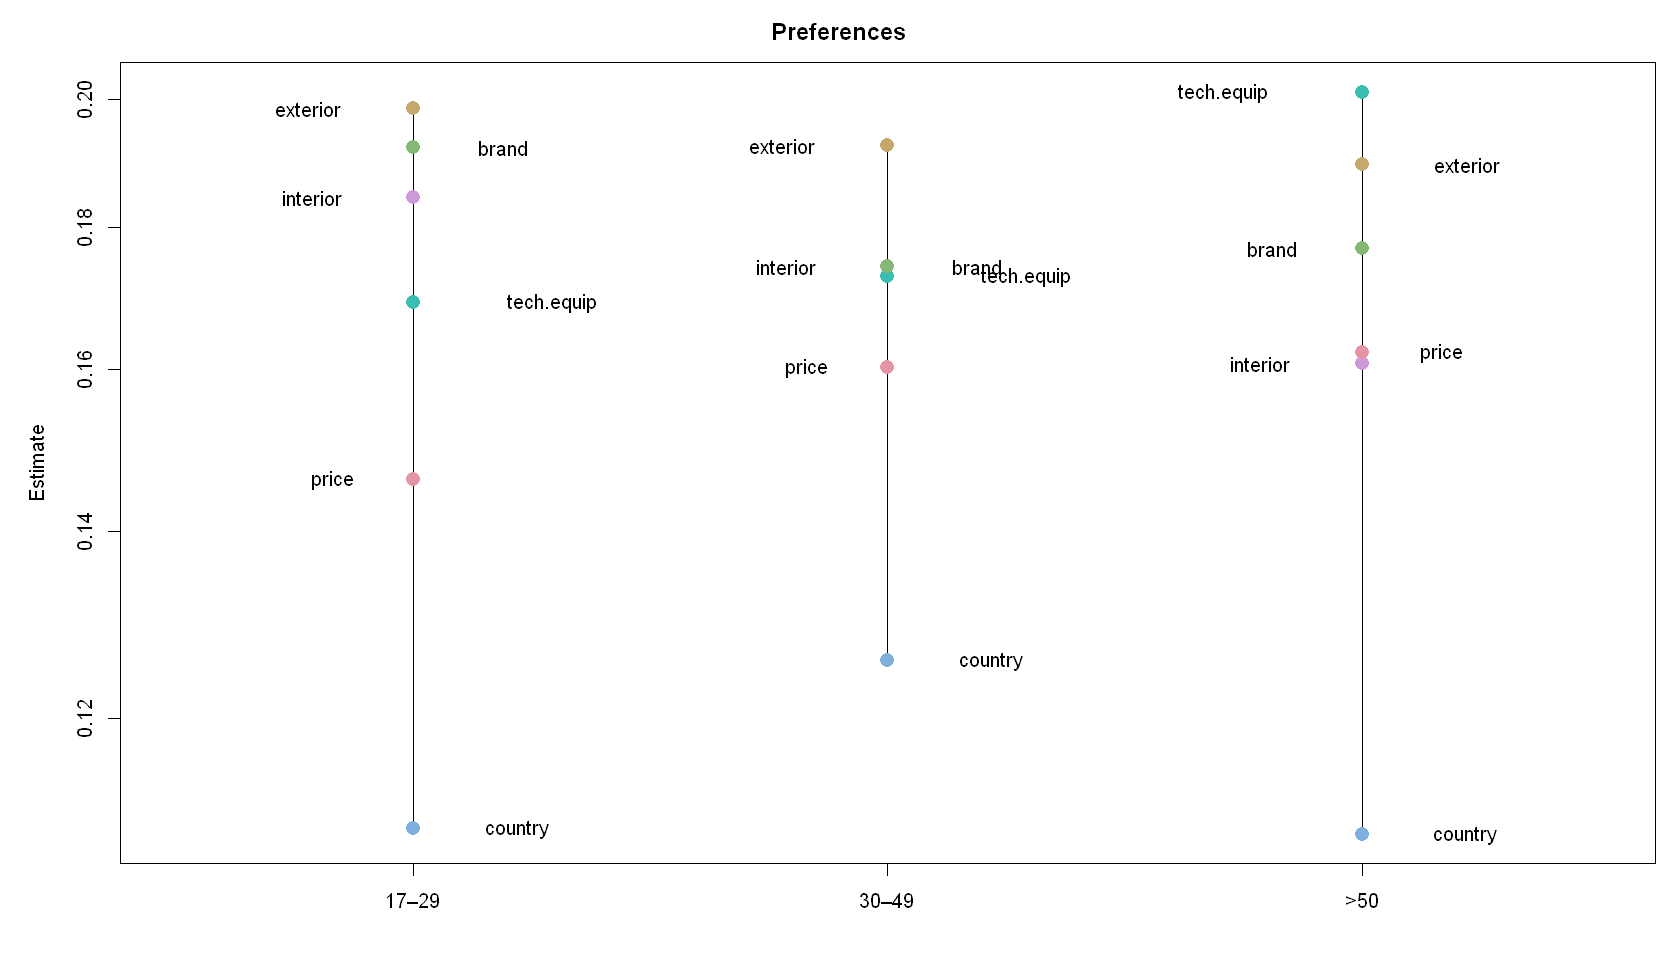

In [23]:
options(repr.plot.width=14, repr.plot.height=8 )
worth_age<-patt.worth(mod.car.age)
colnames(worth_age)<-c(levels(carconf_vis$age))
plot(worth_age,log="y") 